In [31]:
import os
import glob
import tiktoken
import numpy as np
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from IPython.display import Image

In [32]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-4.1-nano"
db_name = "vector_db"
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

OpenAI API Key not set


In [33]:
# How many characters in all the documents?

knowledge_base_path = "/Users/yuvraj/Downloads/llm_engineering-main/week5/knowledge-base/**/*.md"
files = glob.glob(knowledge_base_path, recursive=True)
print(f"Found {len(files)} files in the knowledge base")

entire_knowledge_base = ""

for file_path in files:
    with open(file_path, 'r', encoding='utf-8') as f:
        entire_knowledge_base += f.read()
        entire_knowledge_base += "\n\n"

print(f"Total characters in knowledge base: {len(entire_knowledge_base):,}")

Found 76 files in the knowledge base
Total characters in knowledge base: 304,434


In [34]:
# How many tokens in all the documents?

encoding = tiktoken.encoding_for_model(MODEL)
tokens = encoding.encode(entire_knowledge_base)
token_count = len(tokens)
print(f"Total tokens for {MODEL}: {token_count:,}")

Total tokens for gpt-4.1-nano: 63,555


In [35]:
# Load in everything in the knowledgebase using LangChain's loaders

folders = glob.glob("/Users/yuvraj/Downloads/llm_engineering-main/week5/knowledge-base/*")

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs={'encoding': 'utf-8'})
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

print(f"Loaded {len(documents)} documents")

Loaded 76 documents


In [36]:
# documents[1]

In [37]:
# Divide into chunks using the RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Divided into {len(chunks)} chunks")
# print(f"First chunk:\n\n{chunks[0]}")

Divided into 413 chunks


In [38]:
# chunks[100]

In [39]:
# Pick an embedding model

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
#embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 413 documents


In [40]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 413 vectors with 384 dimensions in the vector store


In [41]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]


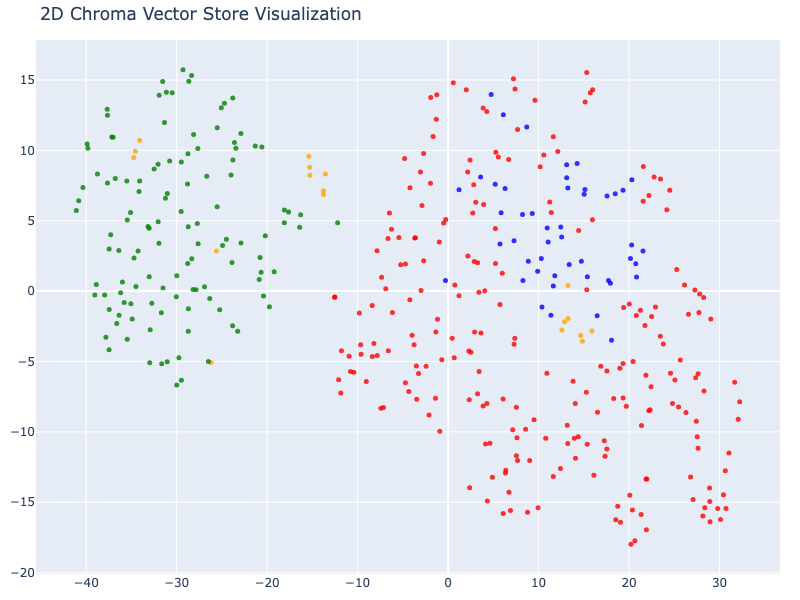

In [43]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

# fig.show()
#fig.write_image("plot_01.png")
Image(filename="plot_01.png")

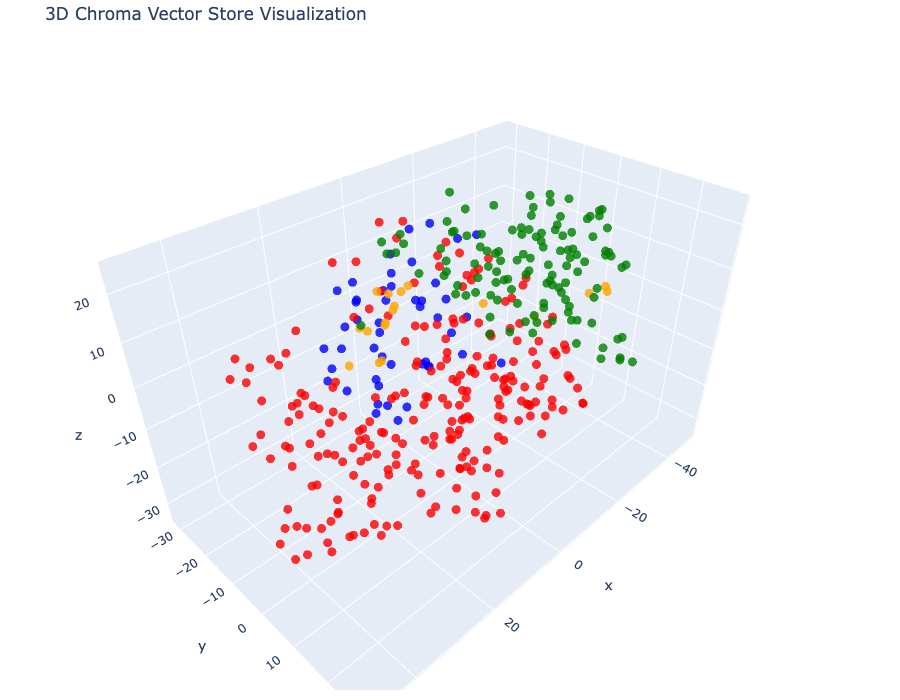

In [45]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=10, b=10, l=10, t=40)
)

fig.show()
fig.write_image("plot_02.png")
Image(filename="plot_02.png")